# Airline Passengers Prediction 
Time series prediction problems are a difficult type of predictive modeling problem.

Unlike regression predictive modeling, time series also adds the complexity of a sequence dependence among the input variables.

A powerful type of neural network designed to handle sequence dependence is called recurrent neural networks. The Long Short-Term Memory network or LSTM network is a type of recurrent neural network used in deep learning because very large architectures can be successfully trained.

In this post, you will discover how to develop LSTM networks in Python using the Keras deep learning library to address a demonstration time-series prediction problem.

After completing this tutorial you will know how to implement and develop LSTM networks for your own time series prediction problems and other more general sequence problems. You will know:

    About the International Airline Passengers time-series prediction problem.
    How to develop LSTM networks for regression, window and time-step based framing of time series prediction problems.
    How to develop and make predictions using LSTM networks that maintain state (memory) across very long sequences.

In this tutorial, we will develop a number of LSTMs for a standard time series prediction problem. The problem and the chosen configuration for the LSTM networks are  for demonstration purposes only they are not optimized.

These examples will show you exactly how you can develop your own differently structured LSTM networks for time series predictive modeling problems.
# Problem Description

The problem we are going to look at in this post is theInternational Airline Passengers prediction problem.

This is a problem where, given a year and a month, the task is to predict the number of international airline passengers in units of 1,000. The data ranges from January 1949 to December 1960, or 12 years, with 144 observations.
We can load this dataset easily using the Pandas library. We are not interested in the date, given that each observation is separated by the same interval of one month. Therefore, when we load the dataset we can exclude the first column.

Once loaded we can easily plot the whole dataset. The code to load and plot the dataset is listed below.

In [20]:
import pandas
import matplotlib.pyplot as plt
dataset = pandas.read_csv('C:/Users/rzouga/Downloads/Github/TimeSeriesData/Airline.csv', sep=',', usecols=[0],engine='python')
dataset.head()

,MonthPassengers
0,"""1949-01"",112"
1,"""1949-02"",118"
2,"""1949-03"",132"
3,"""1949-04"",129"
4,"""1949-05"",121"


In [24]:
dataset['Year'] = dataset.MonthPassengers.apply(lambda x: x[1:5])
dataset['Month'] = dataset.MonthPassengers.apply(lambda x: x[6:8])
dataset['Passengers'] = dataset.MonthPassengers.apply(lambda x: x[10:13])
dataset.head()

,MonthPassengers,Month,Year,Passengers
0,"""1949-01"",112",01,1949,112
1,"""1949-02"",118",02,1949,118
2,"""1949-03"",132",03,1949,132
3,"""1949-04"",129",04,1949,129
4,"""1949-05"",121",05,1949,121


In [25]:
dataset['New_sample'] = dataset['MonthPassengers'].str.slice(1,5)
dataset.head()

,MonthPassengers,Month,Year,Passengers,New_sample
0,"""1949-01"",112",01,1949,112,1949
1,"""1949-02"",118",02,1949,118,1949
2,"""1949-03"",132",03,1949,132,1949
3,"""1949-04"",129",04,1949,129,1949
4,"""1949-05"",121",05,1949,121,1949


# Second method to extrat information in general 
# Convert the dictionary to a dataframe 
df = pd.DataFrame(dict) 
  
# Extract name from the string  
df['Name'] = df['movie_data'].str.extract('(\w*\s\w*)', expand=True) 
   
# Extract year from the string  
df['Year'] = df['movie_data'].str.extract('(\d\d\d\d)', expand=True) 
  
# Extract rating from the string  
df['Rating'] = df['movie_data'].str.extract('(\d\.\d)', expand=True) 
print(df) 

You can see an upward trend in the dataset over time.

You can also see some periodicity to the dataset that probably corresponds to the Northern Hemisphere vacation period.

In [34]:
dataset=dataset.loc[:,'Passengers']
dataset.head()

0    112
1    118
2    132
3    129
4    121
Name: Passengers, dtype: object

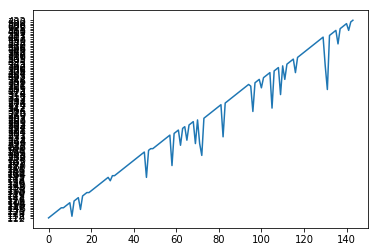

In [35]:
plt.plot(dataset)
plt.show()

We are going to keep things simple and work with the data as-is.

Normally, it is a good idea to investigate various data preparation techniques to rescale the data and to make it stationary.
# Long Short-Term Memory Network

The Long Short-Term Memory network, or LSTM network, is a recurrent neural network that is trained using Backpropagation Through Time and overcomes the vanishing gradient problem.

As such, it can be used to create large recurrent networks that in turn can be used to address difficult sequence problems in machine learning and achieve state-of-the-art results.

Instead of neurons, LSTM networks have memory blocks that are connected through layers.

A block has components that make it smarter than a classical neuron and a memory for recent sequences. A block contains gates that manage the block’s state and output. A block operates upon an input sequence and each gate within a block uses the sigmoid activation units to control whether they are triggered or not, making the change of state and addition of information flowing through the block conditional.

There are three types of gates within a unit:

    Forget Gate: conditionally decides what information to throw away from the block.
    Input Gate: conditionally decides which values from the input to update the memory state.
    Output Gate: conditionally decides what to output based on input and the memory of the block.

Each unit is like a mini-state machine where the gates of the units have weights that are learned during the training procedure.

You can see how you may achieve sophisticated learning and memory from a layer of LSTMs, and it is not hard to imagine how higher-order abstractions may be layered with multiple such layers.
# LSTM Network for Regression

We can phrase the problem as a regression problem.

That is, given the number of passengers (in units of thousands) this month, what is the number of passengers next month?

We can write a simple function to convert our single column of data into a two-column dataset: the first column containing this month’s (t) passenger count and the second column containing next month’s (t+1) passenger count, to be predicted.

Before we get started, let’s first import all of the functions and classes we intend to use. This assumes a working SciPy environment with the Keras deep learning library installed.

In [38]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Before we do anything, it is a good idea to fix the random number seed to ensure our results are reproducible

In [39]:
# fix random seed for reproducibility
numpy.random.seed(7)

We can also use the code from the previous section to load the dataset as a Pandas dataframe. We can then extract the NumPy array from the dataframe and convert the integer values to floating point values, which are more suitable for modeling with a neural network.

In [ ]:
We can also use the code from the previous section to load the dataset as a Pandas dataframe. We can then extract the NumPy array from the dataframe and convert the integer values to floating point values, which are more suitable for modeling with a neural network.

In [40]:
dataset = dataset.values
dataset = dataset.astype('float32')

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

In [47]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))


In [46]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


Now we can define a function to create a new dataset, as described above.

The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1.

This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).

It can be configured, and we will by constructing a differently shaped dataset in the next section.

In [49]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

Let’s take a look at the effect of this function on the first rows of the dataset (shown in the unnormalized form for clarity).
If you compare these first 5 rows to the original dataset sample listed in the previous section, you can see the X=t and Y=t+1 pattern in the numbers.

Let’s use this function to prepare the train and test datasets for modeling.

In [54]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
(trainX[0:3],trainY[0:3])

(array([[0.01544401],
        [0.02702703],
        [0.05405405]], dtype=float32),
 array([0.02702703, 0.05405405, 0.04826255], dtype=float32))

In [58]:
# second
import numpy as np
def create_dataset1(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)
look_back = 1
trainX1, trainY1 = create_dataset1(train,train ,look_back)
testX1, testY1 = create_dataset1(test,test, look_back)
(trainX1[0:3],trainY1[0:3])

(array([[[0.01544401]],
 
        [[0.02702703]],
 
        [[0.05405405]]], dtype=float32), array([[0.02702703],
        [0.05405405],
        [0.04826255]], dtype=float32))

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].

Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [59]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

We are now ready to design and fit our LSTM network for this problem.

The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.

In [61]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

Once the model is fit, we can estimate the performance of the model on the train and test datasets. This will give us a point of comparison for new models.

Note that we invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data (thousands of passengers per month).

In [62]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.04 RMSE
Test Score: 0.10 RMSE


Finally, we can generate predictions using the model for both the train and test dataset to get a visual indication of the skill of the model.

Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in red.

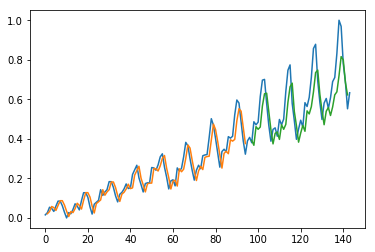

In [63]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# LSTM for Regression Using the Window Method

We can also phrase the problem so that multiple, recent time steps can be used to make the prediction for the next time step.

This is called a window, and the size of the window is a parameter that can be tuned for each problem.

For example, given the current time (t) we want to predict the value at the next time in the sequence (t+1), we can use the current time (t), as well as the two prior times (t-1 and t-2) as input variables.

When phrased as a regression problem, the input variables are t-2, t-1, t and the output variable is t+1.

The create_dataset() function we created in the previous section allows us to create this formulation of the time series problem by increasing the look_back argument from 1 to 3.

A sample of the dataset with this formulation looks as follows:
https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/